## Time Series Analysis of Precipitation and Soil Mositure

In [1]:
import bqplot
import datetime
import dateutil.parser
import ee
import ipywidgets
import IPython.display
import numpy as np
import pprint
import pandas as pd
import traitlets
import ipyleaflet
from matplotlib.pyplot import *

# Configure the pretty printing output.
pp = pprint.PrettyPrinter(depth=4)

In [2]:
# Authenticate to the Earth Engine servers, and initialize the ee module.
ee.Initialize()

## Load and display GPM Data

In [3]:
gpm_collection = ee.ImageCollection("NASA/GPM_L3/IMERG_V05")

In [4]:
print(gpm_collection.size().getInfo())

86584


In [5]:
# filter gpm collection
gpm_collection_18 = gpm_collection.filterDate('2018-01-01', '2018-12-31')
print(gpm_collection_18.size().getInfo())

17472


In [6]:
# sample gpm image analysis
gpm_image = ee.Image(gpm_collection_18
         #.filterBounds(india_region.geometry())
         .first()
        )

In [7]:
# Get information about the bands as a list.
bandNames = gpm_image.bandNames();
print('Band names: ', bandNames.getInfo()); 

#Get a list of all metadata properties.
properties = gpm_image.propertyNames();
print('Metadata properties: ', properties.getInfo()); 

#Get a specific metadata property.
cloudiness = gpm_image.get('CLOUD_COVER');
print('CLOUD_COVER: ', cloudiness.getInfo()); 

#Get the timestamp and convert it to a date.
date = ee.Date(gpm_image.get('system:time_start'));
print('Timestamp: ', date.getInfo()); 
 
# Get dimensions of imagees
print (gpm_image.geometry().bounds().getInfo());

#pp.pprint(gpm_image.getInfo())

Band names:  ['HQobservationTime', 'HQprecipSource', 'HQprecipitation', 'IRkalmanFilterWeight', 'IRprecipitation', 'precipitationCal', 'precipitationUncal', 'probabilityLiquidPrecipitation', 'randomError']
Metadata properties:  ['system:time_start', 'system:footprint', 'system:time_end', 'system:version', 'system:id', 'system:asset_size', 'status', 'system:index', 'system:bands', 'system:band_names']
CLOUD_COVER:  None
Timestamp:  {'type': 'Date', 'value': 1514764800000}
{'type': 'Polygon', 'coordinates': [[[-180.0, -90.0], [180.0, -90.0], [180.0, 90.0], [-180.0, 90.0], [-180.0, -90.0]]]}


In [9]:
gpm_thumbnail_url = gpm_image.getThumbUrl({
    'bands': 'precipitationCal',
    'min': 1.0,
    'max': 9.0,
    #'region': gpm_image.geometry().bounds().getInfo()
})
IPython.display.HTML('Thumbnail URL: <a href={0}>{0}</a>'.format(gpm_thumbnail_url))
IPython.display.Image(url=gpm_thumbnail_url)

In [10]:
gpm_map = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
gpm_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [11]:
def GetTileLayerUrl(ee_image_object):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
  return tile_url_template.format(**map_id)

In [12]:
# overaly image on map
tile_url = GetTileLayerUrl(gpm_image.visualize(min=1.0, max=9.0, gamma=1.5, bands= ['precipitationCal']))
gpm_map.add_layer(ipyleaflet.TileLayer(url=tile_url))

## Load and display Soil Moisture Data

In [13]:
soil_moist_collection = ee.ImageCollection('NASA_USDA/HSL/SMAP_soil_moisture')

In [14]:
print(soil_moist_collection.size().getInfo())

471


In [15]:
# filter soil moisture collection
soil_moist_collection_18 = soil_moist_collection.filterDate('2018-01-01', '2018-12-31')
print(soil_moist_collection_18.size().getInfo())

122


In [16]:
# sample soil moisture image analysis
soil_moist_image = ee.Image(soil_moist_collection_18.first())

In [17]:
# Get information about the bands as a list.
bandNames = soil_moist_image.bandNames();
print('Band names: ', bandNames.getInfo()); 

#Get a list of all metadata properties.
properties = soil_moist_image.propertyNames();
print('Metadata properties: ', properties.getInfo()); 

#Get a specific metadata property.
cloudiness = soil_moist_image.get('CLOUD_COVER');
print('CLOUD_COVER: ', cloudiness.getInfo());

#Get the timestamp and convert it to a date.
date = ee.Date(soil_moist_image.get('system:time_start'));
print('Timestamp: ', date.getInfo()); 
 
# Get dimensions of imagees
print (soil_moist_image.geometry().bounds().getInfo());

# print image metadata
#pp.pprint(soil_moist_image.getInfo())

Band names:  ['ssm', 'susm', 'smp', 'ssma', 'susma']
Metadata properties:  ['system:time_start', 'system:footprint', 'system:time_end', 'system:version', 'system:id', 'ID', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
CLOUD_COVER:  None
Timestamp:  {'type': 'Date', 'value': 1514764800000}
{'type': 'Polygon', 'coordinates': [[[-180.0, -90.0], [180.0, -90.0], [180.0, 90.0], [-180.0, 90.0], [-180.0, -90.0]]]}


In [19]:
soil_moist_thumbnail_url = soil_moist_image.getThumbUrl({
    'bands': 'ssm',
    'min': 0.0,
    'max': 28.0,
})
IPython.display.HTML('Thumbnail URL: <a href={0}>{0}</a>'.format(soil_moist_thumbnail_url))
IPython.display.Image(url=soil_moist_thumbnail_url)

In [20]:
soil_moist_map = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
soil_moist_tile_url = GetTileLayerUrl(soil_moist_image.visualize(min=0.0, max=28.0, gamma=1.5, bands= ['ssm']))
soil_moist_map.add_layer(ipyleaflet.TileLayer(url=soil_moist_tile_url))
soil_moist_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Aggregate Precipitation and Soil Moisture over a Time Series

In [21]:
from datetime import datetime
from datetime import timedelta

sum_monthly_precipitation = [];
mean_monthly_soil_moisture = [];

months_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

start_dt = '2018-01-01'
finish_dt = '2018-01-31'

for days in months_days:
    gpm_current_month = gpm_collection_18.filterDate(start_dt, finish_dt)
    soil_moist_current_month = soil_moist_collection_18.filterDate(start_dt, finish_dt)
    
    sum_monthly_precipitation.append(gpm_current_month.reduce(ee.Reducer.sum()));
    mean_monthly_soil_moisture.append(soil_moist_current_month.reduce(ee.Reducer.mean()))
    
    start_dt = datetime.strptime(start_dt, '%Y-%m-%d')
    finish_dt = datetime.strptime(finish_dt, '%Y-%m-%d')
    start_dt = (start_dt + timedelta(days=months_days[(start_dt.month%12) -1])).strftime('%Y-%m-%d')
    finish_dt = (finish_dt + timedelta(days=months_days[finish_dt.month%12])).strftime('%Y-%m-%d')

In [22]:
sum_monthly_precipitation_collection = ee.ImageCollection.fromImages(sum_monthly_precipitation);
mean_monthly_soil_moisture_collection = ee.ImageCollection.fromImages(mean_monthly_soil_moisture);

In [23]:
month_precipitation_map = ipyleaflet.Map(zoom=2, layout={'height':'400px'})
tile_url = GetTileLayerUrl(sum_monthly_precipitation_collection.first().visualize(min=1.0, max=9.0, gamma=1.5, bands= ['precipitationCal_sum']))
month_precipitation_map.add_layer(ipyleaflet.TileLayer(url=tile_url))
month_precipitation_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [24]:
month_soil_moist_map = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
tile_url = GetTileLayerUrl(mean_monthly_soil_moisture_collection.first().visualize(min=0.0, max=28.0, gamma=1.5, bands= ['ssm_mean']))
month_soil_moist_map.add_layer(ipyleaflet.TileLayer(url=tile_url))
month_soil_moist_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [25]:
# sample point
point = {'type':'Point', 'coordinates':[ -116.88629,36.56122]};

precipitaion_info = sum_monthly_precipitation_collection.getRegion(point,500).getInfo()
soil_moisture_info = mean_monthly_soil_moisture_collection.getRegion(point,500).getInfo()

In [26]:
# column names and data for precipitation
precipitaion_data_header = precipitaion_info[0]
precipitaion_data = np.array(precipitaion_info[1:])

# column names and data for soil moisture
soil_moisture_data_header = soil_moisture_info[0]
soil_moisture_data = np.array(soil_moisture_info[1:])

print (soil_moisture_data_header)
print (precipitaion_data_header)

['id', 'longitude', 'latitude', 'time', 'ssm_mean', 'susm_mean', 'smp_mean', 'ssma_mean', 'susma_mean']
['id', 'longitude', 'latitude', 'time', 'HQobservationTime_sum', 'HQprecipSource_sum', 'HQprecipitation_sum', 'IRkalmanFilterWeight_sum', 'IRprecipitation_sum', 'precipitationCal_sum', 'precipitationUncal_sum', 'probabilityLiquidPrecipitation_sum', 'randomError_sum']


In [27]:
month_indices = np.arange(0, 12)

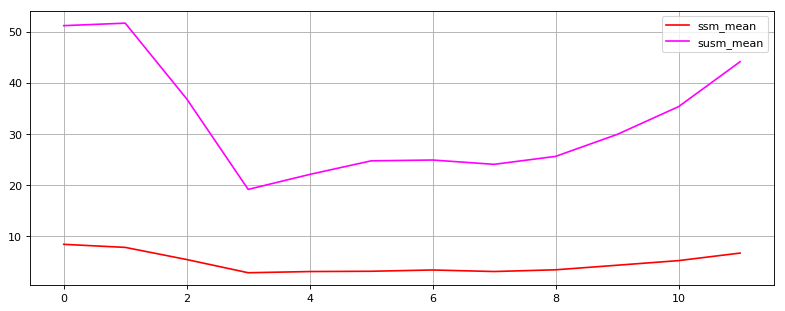

In [33]:
fig = figure(figsize=(12,10), dpi=80)

# plot the soil moisture values
ax1 = fig.add_subplot(211)
ax1.plot(month_indices, soil_moisture_data[:,soil_moisture_data_header.index('ssm_mean')], 
         color="red", label="ssm_mean")
ax1.plot(month_indices, soil_moisture_data[:,soil_moisture_data_header.index('susm_mean')], 
         color="magenta",  label="susm_mean")
ax1.legend(loc='best')
ax1.grid(True)

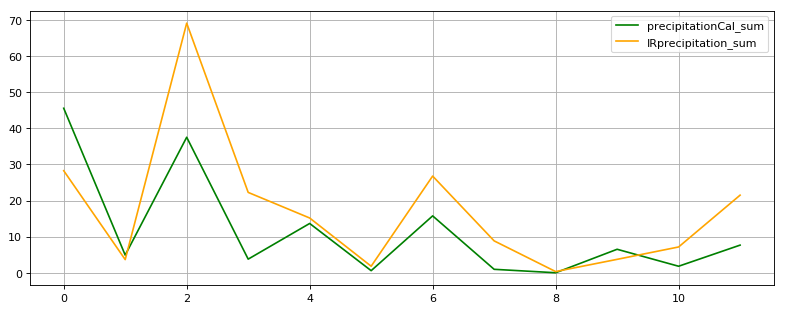

In [31]:
fig2 = figure(figsize=(12,10), dpi=80)

ax2 = fig2.add_subplot(212)
ax2.plot(month_indices, precipitaion_data[:,precipitaion_data_header.index('precipitationCal_sum')], 
         color="green", label="precipitationCal_sum")
ax2.plot(month_indices, precipitaion_data[:,precipitaion_data_header.index('IRprecipitation_sum')], 
         color="orange",  label="IRprecipitation_sum")

ax2.legend(loc='best')
ax2.grid(True)